<h1> Preprocessing using tf.transform and Dataflow </h1>

This notebook illustrates:
<ol>
<li> Creating datasets for Machine Learning using tf.transform and Dataflow
</ol>
<p>
While Pandas is fine for experimenting, for operationalization of your workflow, it is better to do preprocessing in Apache Beam. This will also help if you need to preprocess data in flight, since Apache Beam also allows for streaming.

Apache Beam only works in Python 2 at the moment, so we're going to switch to the Python 2 kernel. In the above menu, click the dropdown arrow and select `python2`. 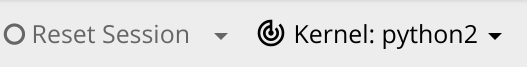

Then activate a Python 2 environment and install Apache Beam. Only specific combinations of TensorFlow/Beam are supported by tf.transform. So make sure to get a combo that is.
* TFT 0.8.0
* TF 1.8 or higher
* Apache Beam [GCP] 2.5.0 or higher

In [ ]:
%%bash
conda update -y -n base -c defaults conda
source activate py2env
pip uninstall -y google-cloud-dataflow
conda install -y pytz
pip install apache-beam[gcp]==2.9.0
pip install apache-beam[gcp] tensorflow_transform==0.8.0


In [1]:
%%bash
pip freeze | grep -e 'flow\|beam'

apache-airflow==1.9.0
google-cloud-dataflow==2.0.0
tensorflow==1.8.0


You need to restart your kernel to register the new installs running the below cells

In [ ]:
import tensorflow as tf
import apache_beam as beam
print(tf.__version__)

In [ ]:
# change these to try this notebook out
BUCKET = 'cloud-training-demos-ml' # REPLACE WITH YOUR PROJECT ID
PROJECT = 'cloud-training-demos' # REPLACE WITH YOUR BUCKET NAME
REGION = 'us-central1'

In [ ]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [ ]:
!gcloud config set project $PROJECT

In [ ]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
  gsutil mb -l ${REGION} gs://${BUCKET}
fi

<h2> Save the query from earlier </h2>

The data is natality data (record of births in the US). My goal is to predict the baby's weight given a number of factors about the pregnancy and the baby's mother.  Later, we will want to split the data into training and eval datasets. The hash of the year-month will be used for that.

In [ ]:
query="""
SELECT
  weight_pounds,
  is_male,
  mother_age,
  mother_race,
  plurality,
  gestation_weeks,
  mother_married,
  ever_born,
  cigarette_use,
  alcohol_use,
  FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
"""

In [ ]:
import google.datalab.bigquery as bq
df = bq.Query(query + " LIMIT 100").execute().result().to_dataframe()
df.head()

<h2> Create ML dataset using tf.transform and Dataflow </h2>
<p>
Let's use Cloud Dataflow to read in the BigQuery data and write it out as CSV files. Along the way, let's use tf.transform to do scaling and transforming. Using tf.transform allows us to save the metadata to ensure that the appropriate transformations get carried out during prediction as well.
<p>
Note that after you launch this, the notebook won't show you progress. Go to the GCP webconsole to the Dataflow section and monitor the running job. It took about <b>30 minutes</b> for me. If you wish to continue without doing this step, you can copy my preprocessed output:
<pre>
gsutil -m cp -r gs://cloud-training-demos/babyweight/preproc_tft gs://your-bucket/
</pre>

In [ ]:
%writefile requirements.txt
tensorflow-transform==0.8.0

In [ ]:
import datetime
import apache_beam as beam
import tensorflow_transform as tft
from tensorflow_transform.beam import impl as beam_impl

def preprocess_tft(inputs):
    import copy
    import numpy as np
    def center(x):
          return x - tft.mean(x)
    result = copy.copy(inputs) # shallow copy
    result['mother_age_tft'] = center(inputs['mother_age'])
    result['gestation_weeks_centered'] = tft.scale_to_0_1(inputs['gestation_weeks'])
    result['mother_race_tft'] = tft.string_to_int(inputs['mother_race'])
    return result
    #return inputs

def cleanup(rowdict):
    import copy, hashlib
    CSV_COLUMNS = 'weight_pounds,is_male,mother_age,mother_race,plurality,gestation_weeks,mother_married,cigarette_use,alcohol_use'.split(',')
    STR_COLUMNS = 'key,is_male,mother_race,mother_married,cigarette_use,alcohol_use'.split(',')
    FLT_COLUMNS = 'weight_pounds,mother_age,plurality,gestation_weeks'.split(',')
    
    # add any missing columns, and correct the types
    def tofloat(value, ifnot):
      try:
        return float(value)
      except (ValueError, TypeError):
        return ifnot

    result = {
      k : str(rowdict[k]) if k in rowdict else 'None' for k in STR_COLUMNS
    }
    result.update({
        k : tofloat(rowdict[k], -99) if k in rowdict else -99 for k in FLT_COLUMNS
      })
    
    # modify opaque numeric race code into human-readable data
    races = dict(zip([1,2,3,4,5,6,7,18,28,39,48],
                     ['White', 'Black', 'American Indian', 'Chinese', 
                      'Japanese', 'Hawaiian', 'Filipino',
                      'Asian Indian', 'Korean', 'Samaon', 'Vietnamese'])) 
    if 'mother_race' in rowdict and rowdict['mother_race'] in races:
      result['mother_race'] = races[rowdict['mother_race']]
    else:
      result['mother_race'] = 'Unknown'    
    
    # cleanup: write out only the data we that we want to train on
    if result['weight_pounds'] > 0 and result['mother_age'] > 0 and result['gestation_weeks'] > 0 and result['plurality'] > 0:
      data = ','.join([str(result[k]) for k in CSV_COLUMNS])
      result['key'] = hashlib.sha224(data).hexdigest()
      yield result 
  
def preprocess(query, in_test_mode):
  import os
  import os.path
  import tempfile
  import tensorflow as tf
  from apache_beam.io import tfrecordio
  from tensorflow_transform.coders import example_proto_coder
  from tensorflow_transform.tf_metadata import dataset_metadata
  from tensorflow_transform.tf_metadata import dataset_schema
  from tensorflow_transform.beam.tft_beam_io import transform_fn_io

  job_name = 'preprocess-babyweight-features' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')    
  if in_test_mode:
    import shutil
    print('Launching local job ... hang on')
    OUTPUT_DIR = './preproc_tft'
    shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
  else:
    print('Launching Dataflow job {} ... hang on'.format(job_name))
    OUTPUT_DIR = 'gs://{0}/babyweight/preproc_tft/'.format(BUCKET)
    import subprocess
    subprocess.call('gsutil rm -r {}'.format(OUTPUT_DIR).split())
    
  options = {
    'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
    'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
    'job_name': job_name,
    'project': PROJECT,
    'region': REGION,
    'max_num_workers': 6,
    'teardown_policy': 'TEARDOWN_ALWAYS',
    'no_save_main_session': True,
    'requirements_file': 'requirements.txt'
  }
  opts = beam.pipeline.PipelineOptions(flags=[], **options)
  if in_test_mode:
    RUNNER = 'DirectRunner'
  else:
    RUNNER = 'DataflowRunner'

  # set up metadata  
  raw_data_schema = {
    colname : dataset_schema.ColumnSchema(tf.string, [], dataset_schema.FixedColumnRepresentation())
                   for colname in 'key,is_male,mother_race,mother_married,cigarette_use,alcohol_use'.split(',')
  }
  raw_data_schema.update({
      colname : dataset_schema.ColumnSchema(tf.float32, [], dataset_schema.FixedColumnRepresentation())
                   for colname in 'weight_pounds,mother_age,plurality,gestation_weeks'.split(',')
    })
  raw_data_metadata = dataset_metadata.DatasetMetadata(dataset_schema.Schema(raw_data_schema))

  def read_rawdata(p, step, test_mode):
    if step == 'train':
        selquery = 'SELECT * FROM ({}) WHERE MOD(ABS(hashmonth),4) < 3'.format(query)
    else:
        selquery = 'SELECT * FROM ({}) WHERE MOD(ABS(hashmonth),4) = 3'.format(query)
    if in_test_mode:
        selquery = selquery + ' LIMIT 100'
    #print('Processing {} data from {}'.format(step, selquery))
    return (p 
          | '{}_read'.format(step) >> beam.io.Read(beam.io.BigQuerySource(query=selquery, use_standard_sql=True))
          | '{}_cleanup'.format(step) >> beam.FlatMap(cleanup)
                   )
  
  # run Beam  
  with beam.Pipeline(RUNNER, options=opts) as p:
    with beam_impl.Context(temp_dir=os.path.join(OUTPUT_DIR, 'tmp')):

      # analyze and transform training       
      raw_data = read_rawdata(p, 'train', in_test_mode)
      raw_dataset = (raw_data, raw_data_metadata)
      transformed_dataset, transform_fn = (
          raw_dataset | beam_impl.AnalyzeAndTransformDataset(preprocess_tft))
      transformed_data, transformed_metadata = transformed_dataset
      _ = transformed_data | 'WriteTrainData' >> tfrecordio.WriteToTFRecord(
          os.path.join(OUTPUT_DIR, 'train'),
          coder=example_proto_coder.ExampleProtoCoder(
              transformed_metadata.schema))
      
      # transform eval data
      raw_test_data = read_rawdata(p, 'eval', in_test_mode)
      raw_test_dataset = (raw_test_data, raw_data_metadata)
      transformed_test_dataset = (
          (raw_test_dataset, transform_fn) | beam_impl.TransformDataset())
      transformed_test_data, _ = transformed_test_dataset
      _ = transformed_test_data | 'WriteTestData' >> tfrecordio.WriteToTFRecord(
          os.path.join(OUTPUT_DIR, 'eval'),
          coder=example_proto_coder.ExampleProtoCoder(
              transformed_metadata.schema))
      _ = (transform_fn
           | 'WriteTransformFn' >>
           transform_fn_io.WriteTransformFn(os.path.join(OUTPUT_DIR, 'metadata')))

  job = p.run()
  if in_test_mode:
    job.wait_until_finish()
    print("Done!")
  
preprocess(query, in_test_mode=False)

In [ ]:
%bash
gsutil ls gs://${BUCKET}/babyweight/preproc_tft/*-00000*

Copyright 2017 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License